# Usando o Hanged Man e Jogando
Você pode usar as células abaixo para jogar com o Hanged Man:

In [1]:
import pandas as pd
from HangedMan import HangedMan

# Este é o dataframe de palavras que DEVE ser passado para o jogador
df = pd.read_csv("br-sem-acentos.txt", header=None, names=['word'])
df['word'] = df['word'].str.lower()

jogador = HangedMan(df)

Os detalhes da implementação do agente estão totalmente comentados dentro do arquivo `HangedMan.py`

In [2]:
# Para jogar, você deve rodar essa célula.

# Se nada for passado dentro da função play, o jogo escolhe uma palavra aleatória!
jogo1 = jogador.play(palavra="")
print("A palavra escolhida foi: " + jogo1[1] + " a palavra que o jogador chutou foi: " + jogo1[2] + "\n")

# Se uma palavra válida for passada dentro da função, o jogador tenta acertar essa palavra!
jogo2 = jogador.play(palavra="acertar")
print("A palavra escolhida foi: " + jogo2[1] + " a palavra que o jogador chutou foi: " + jogo2[2] + "\n")

# Se uma palavra inválida for passada, o jogo escolhe uma palavra aleatória!
jogo3 = jogador.play(palavra="nãodevepassarpalavrascomacentooupontuacao!")
print("A palavra escolhida foi: " + jogo3[1] + " a palavra que o jogador chutou foi: " + jogo3[2] + "\n")

A palavra escolhida foi: leproso a palavra que o jogador chutou foi: leproso

A palavra escolhida foi: acertar a palavra que o jogador chutou foi: acertar

A palavra passada foi inválida! Outra palavra foi escolhida
A palavra escolhida foi: julgariam a palavra que o jogador chutou foi: culpariam



# Testes com o Jogador (HangedMan)
### Letras e suas frequências
Como mencionado no `README.md`, a frequência na qual as letras aparecem nas palavras é de muita relevância para o funcionamento do jogador, portanto o primeiro teste foi realizar a leitura do dataframe, obtendo as frequências de cada uma das letras:

In [3]:
import pandas as pd

# Primeiro, quantas vezes cada letra aparece nas palavras?
df = pd.read_csv("br-sem-acentos.txt", header=None, names=['word'])
df['word'] = df['word'].str.lower()

alphabet = 'abcdefghijklmnopqrstuvwxyz'

letter_counts = {}
for word in df['word']:
    counts = {i:0 for i in alphabet}
    for letter in word:
        counts[letter] += 1
    letter_counts[word] = counts
# dataframe que cada coluna é uma letra, e cada linha é uma palavra

df = pd.DataFrame.from_dict(letter_counts, orient='index')

df_ = df.reset_index(drop=True)
letter_counts = df_.sum().sort_values(ascending=False)
letter_counts

a    359221
e    287955
s    254971
r    231267
i    218894
o    178830
m    130235
n    106069
t    103521
c    100394
d     81182
u     65787
l     65345
p     52727
v     44079
g     34189
b     30961
f     29942
h     18802
z     18584
j      8477
q      8226
x      7931
k        22
w        18
y         8
dtype: int64

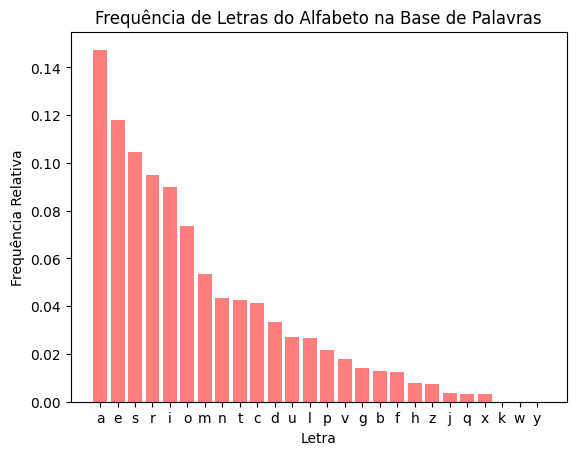

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(letter_counts.index, height=letter_counts.values/letter_counts.sum(), color='red', alpha=0.5)
plt.title("Frequência de Letras do Alfabeto na Base de Palavras")
plt.xlabel("Letra")
plt.ylabel("Frequência Relativa")
plt.show()

In [17]:
# E suas frequências relativas
letter_counts/letter_counts.sum()

a    0.147364
b    0.012701
c    0.041185
d    0.033304
e    0.118129
f    0.012283
g    0.014025
h    0.007713
i    0.089798
j    0.003478
k    0.000009
l    0.026807
m    0.053427
n    0.043513
o    0.073362
p    0.021630
q    0.003375
r    0.094873
s    0.104598
t    0.042468
u    0.026988
v    0.018083
w    0.000007
x    0.003254
y    0.000003
z    0.007624
dtype: float64

Como podemos ver, letras como k, w e y tem uma frequência insignificante na lista de palavras, e pelo funcionamento do jogador, isso faz com que seja muito difícil acertar palavras com essas letras.

### Tamanhos das palavras
Outro fator importante no cálculo da chance de acertar uma palavra é o tamanho dela. Alguns tamanhos de palavras são mais frequentes do que outros, e isso aumenta a chance de erro, por incluir mais possibilidades. Para saber quantas palavras tinham cada tamanho fizemos o seguinte teste:

In [13]:
import pandas as pd

df = pd.read_csv("br-sem-acentos.txt", header=None, names=['word'])
df['word'] = df['word'].str.lower()

data = pd.DataFrame(columns=["Tamanho","Quantidade"])

for i in range(1,21):
    data.loc[len(data)] = [str(i) + " Letra(s)", len(df[df["word"].str.len() == i])]
data.head(20)

,Tamanho,Quantidade
0,1 Letra(s),3
1,2 Letra(s),62
2,3 Letra(s),296
3,4 Letra(s),1604
4,5 Letra(s),5481
5,6 Letra(s),11397
6,7 Letra(s),20548
7,8 Letra(s),30681
8,9 Letra(s),37390
9,10 Letra(s),39831


Esse dataframe representa a quantidade de palavras com cada número de letras, até 20. 

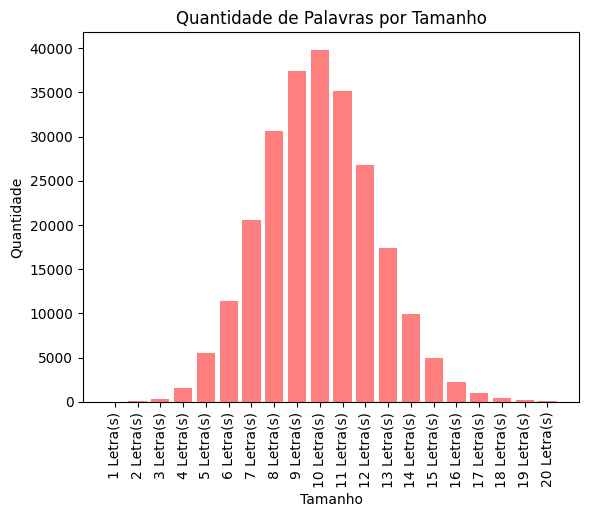

In [15]:
# Como um gráfico de barras

import matplotlib.pyplot as plt


plt.figure()
plt.bar(data["Tamanho"], data["Quantidade"], color='red', alpha=0.5)
plt.title("Quantidade de Palavras por Tamanho")
plt.xlabel("Tamanho")
plt.ylabel("Quantidade")
plt.xticks(rotation=90)
plt.show()

## Acurácia 
Realizamos 1000 jogos, medindo a acurácia do jogador. Também guardamos as informações de todas as palavras que ele errou, para encontrar padrões nelas e fatores que causam o erro:

In [12]:
import pandas as pd
from HangedMan import HangedMan

df = pd.read_csv("br-sem-acentos.txt", header=None, names=['word'])
df['word'] = df['word'].str.lower()
hangedman = HangedMan(df)
data = pd.DataFrame(columns=["Status", "Palavra Correta", "Palavra Tentada"])

ganhou = 0
dict_palavras = {}
for _ in range(1000):
    jogo = hangedman.play()
    if jogo[0]:
        ganhou += 1
        data.loc[len(data)] = ['Ganhou', jogo[1], jogo[2]]
    else:
        data.loc[len(data)] = ['Perdeu', jogo[1], jogo[2]]

In [26]:
print(ganhou/1000)
data[data["Status"] == "Perdeu"].head(20)

0.889


,Status,Palavra Correta,Palavra Tentada
0,Perdeu,pegada,bufava
5,Perdeu,mireis,gireis
7,Perdeu,IMPA,
12,Perdeu,alojassem,afobassem
13,Perdeu,havida,batida
14,Perdeu,mantendo,lambendo
17,Perdeu,comam,colam
24,Perdeu,abanarias,abalarias
34,Perdeu,finalizo,dinamito
37,Perdeu,estorvares,estornares


Como podemos ver, a acurácia atingida foi de aproximadamente 90%. Sobre os erros, analizando as palavras que o jogador errou, e quais palavras ele tentou, podemos analizar os motivos dos erros. Essa análise está no README, e usa informações desse teste.